Number of training examples:  455
Number of testing examples:  114


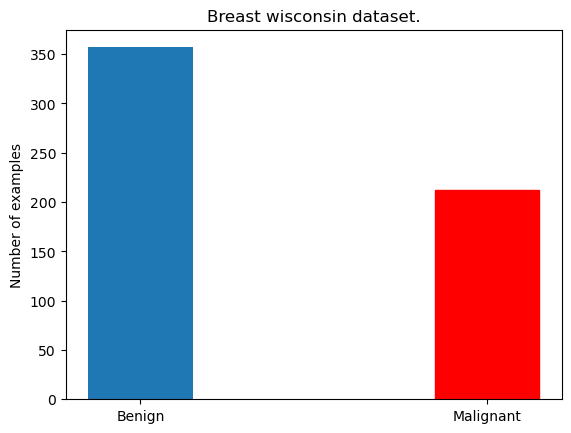

In [127]:
# In this exercise, we are going to classify the breast cancer wisconsin dataset.
# This dataset contains in total 569 examples, among them 212 examples are labelled as malignant (M or 0) and 357 
# examples are marked as benign (B or 1). .Each example is a vector of 30 dimensions.
# We will train a binary logistic regression model using this dataset.

# Load, normalize, split and visualize your dataset. This step has been done for you.
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

# load the dataset
data = load_breast_cancer()
x = data.data
y = data.target

# split into training and test sets, namely 80 percent of examples goes for the training, 20 percent goes for the test set
N_train = int(0.8 * x.shape[0])
x_train = x[:N_train,:]
y_train = y[:N_train]
x_test = x[N_train:,:]
y_test = y[N_train:]

# scale features by removing mean and dividing by the standard deviation
x_bar = np.mean(x_train,axis=0)
x_std = np.std(x_train,axis=0)
x_train_scaled = (x_train - x_bar)/x_std
x_test_scaled = (x_test - x_bar)/x_std

print("Number of training examples: ",x_train.shape[0])
print("Number of testing examples: ",x_test.shape[0])

# visualize the dataset using histogram
labels = ['Benign','Malignant']
population = [np.sum(y),np.sum(y==0)]
y_pos = np.arange(len(labels))
barlist = plt.bar(y_pos, population, align='center',width=0.3)
plt.xticks(y_pos, labels)
plt.ylabel('Number of examples')
plt.title('Breast wisconsin dataset.')
barlist[1].set_color('r')
plt.show()

In [128]:
# Add intercept terms and initialize parameters
# This step has been done for you.
intercept_train = np.ones((N_train,1))
x_train_scaled = np.hstack((intercept_train,x_train_scaled))

intercept_test = np.ones((x.shape[0] - N_train,1))
x_test_scaled = np.hstack((intercept_test,x_test_scaled))

print(x_train_scaled.shape)
print(x_test_scaled.shape)

(455, 31)
(114, 31)


In [129]:
# Step 1: Implement the sigmoid, gradient and cost functions

# this function returns the probability of y=1
def sigmoid(x,theta):
    return 1.0/(1 + np.exp(-np.dot(x,theta)))

# logarithmic loss
def compute_cost(x,y,theta):
    n = len(x)
    h = sigmoid(x,theta)
    return (-1.0/n)*np.sum(np.multiply(y,np.log(sigmoid(x,theta))) + np.multiply((1-y),np.log(1 - sigmoid(x,theta))))

def compute_gradient(x,y,theta):
    n = len(x)
    return (1.0/n)*np.dot(x.T,(sigmoid(x,theta) - y))

def approximate_gradient(x,y,theta,epsilon):
    n_features = x.shape[1]
    app_grad = np.zeros(n_features)
    for i in range(n_features):
        epsilon_one_hot = np.zeros(n_features)
        epsilon_one_hot[i] = epsilon
        theta_before = theta - epsilon_one_hot
        theta_after = theta + epsilon_one_hot
        app_grad[i] = (compute_cost(x,y,theta_after) - compute_cost(x,y,theta_before))/(2*epsilon)
    return app_grad

theta = 0.5 * np.random.randn(x_train_scaled.shape[1])
grad = compute_gradient(x_train_scaled,y_train,theta)
print(grad)
epsilon = 1e-4
app_grad = approximate_gradient(x_train_scaled,y_train,theta,epsilon)
print(app_grad)
print('Sum of gradient squared error: ',np.sum((grad - app_grad)**2))

[-0.22  0.34  0.26  0.35  0.34  0.14  0.29  0.33  0.35  0.09  0.02  0.35
  0.11  0.34  0.34  0.08  0.23  0.2   0.28 -0.02  0.14  0.37  0.27  0.37
  0.36  0.19  0.28  0.32  0.36  0.08  0.17]
[-0.22  0.34  0.26  0.35  0.34  0.14  0.29  0.33  0.35  0.09  0.02  0.35
  0.11  0.34  0.34  0.08  0.23  0.2   0.28 -0.02  0.14  0.37  0.27  0.37
  0.36  0.19  0.28  0.32  0.36  0.08  0.17]
Sum of gradient squared error:  4.938979145471281e-19


training cost: 0.109463


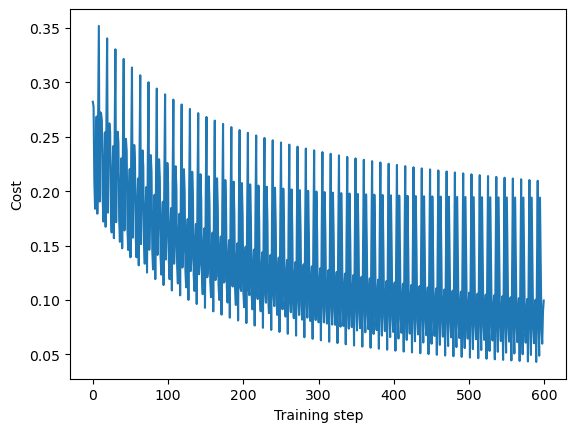

In [130]:
# Step 2: Update model parameters using mini-batch gradient descent algorithm

# try different values for the learning rate
learning_rate = 0.01

# number of training iterations
num_samples = x_train_scaled.shape[0]
batch_size = int(num_samples/10)
N_iterations = int(num_samples / batch_size) * 60  # 20 times the number of training samples

# prepare to plot
plt.subplot(111)

# keep the cost value for each training step
J = np.zeros(N_iterations)

# initialize new parameters using random distribution
theta_msgd = 0.5 * np.random.randn(x_train_scaled.shape[1])

start = 0
end = 0
for step in range(N_iterations):
    if step % (num_samples / batch_size) == 0:
        # shuffle the training data 
        indices = np.random.permutation(num_samples)
        x_train_scaled = x_train_scaled[indices,:]
        y_train = y_train[indices]

    # create a mini-batch of data to train on
    end = start + batch_size
    if end >= num_samples:
        end = num_samples
    x_batch = x_train_scaled[start:end,:]
    y_batch = y_train[start:end]
    start = 0 if end >= num_samples else end
   
    # calculate the cost on x_step and y_step
    J[step] = compute_cost(x_batch,y_batch,theta_msgd)
    
    # update theta_msgd using a x_step and y_step
    theta_msgd = theta_msgd - learning_rate * compute_gradient(x_batch,y_batch,theta_msgd)

# calculate the loss on the whole training set 
J_train = compute_cost(x_train_scaled, y_train, theta_msgd)
print('training cost: %f' %J_train)
# plot cost function
plt.plot(J)
plt.xlabel('Training step')
plt.ylabel('Cost')
plt.show()

Accuracy on test set: 95.61
Test cost:  0.1271968123668322
Confusion matrix, without normalization
[[24  2]
 [ 3 85]]


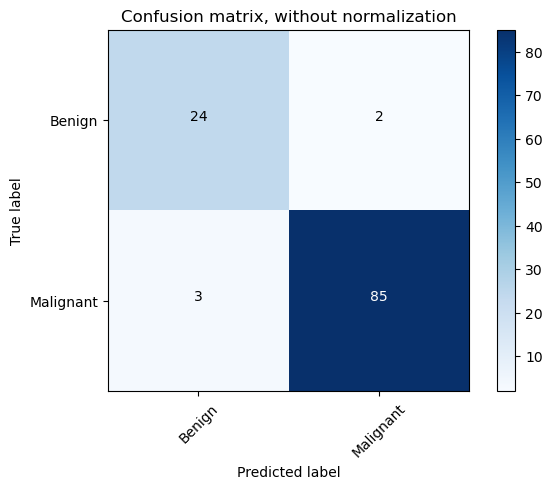

In [131]:
# Step 3: Predict and draw the confusion matrix
# calculate the accuracy
from sklearn.metrics import confusion_matrix
import itertools

# this function draw the confusion matrix, you don't need to touch it.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# In logistic regression, we define a threshold of 0.5
# If the output of our hypothesis is greater than this threshold, the example is classified as 1, otherwise it is given 0
threshold = 0.5
y_pred = (sigmoid(x_test_scaled,theta_msgd) > threshold).astype(int)
print("Accuracy on test set: {:.2f}".format(np.mean(y_pred == y_test)*100))

# calculate the cost for the test set
test_cost = compute_cost(x_test_scaled,y_test,theta_msgd)
print('Test cost: ',test_cost)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [132]:
# For checking with built-in logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train_scaled,y_train)
predicted_labels = model.predict(x_test_scaled) > threshold
print("Accuracy on test set using sklearn logistic regression: ",np.mean(predicted_labels == y_test))

Accuracy on test set using sklearn logistic regression:  0.9824561403508771
